In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from imblearn.over_sampling import SMOTE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score


In [2]:

# Load the CSV file
file_path = 'creditcard.csv' 
df = pd.read_csv(file_path)

In [3]:

# Check for missing data
missing_data = df.isnull().sum()

# Display the count of missing values for each column
print("Missing Data:")
print(missing_data) 

Missing Data:
id        0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64


In [4]:

# Calculate the total number of transactions
total_transactions = len(df)

# Count the number of fraudulent and non-fraudulent transactions
fraudulent_transactions = df['Class'].sum()  # Assuming 1 represents fraudulent
non_fraudulent_transactions = total_transactions - fraudulent_transactions

# Calculate the percentages
fraudulent_percentage = (fraudulent_transactions / total_transactions) * 100
non_fraudulent_percentage = (non_fraudulent_transactions / total_transactions) * 100

# Print the results
print("Percentage of fraudulent transactions:", fraudulent_percentage)
print("Percentage of non-fraudulent transactions:", non_fraudulent_percentage)

Percentage of fraudulent transactions: 50.0
Percentage of non-fraudulent transactions: 50.0


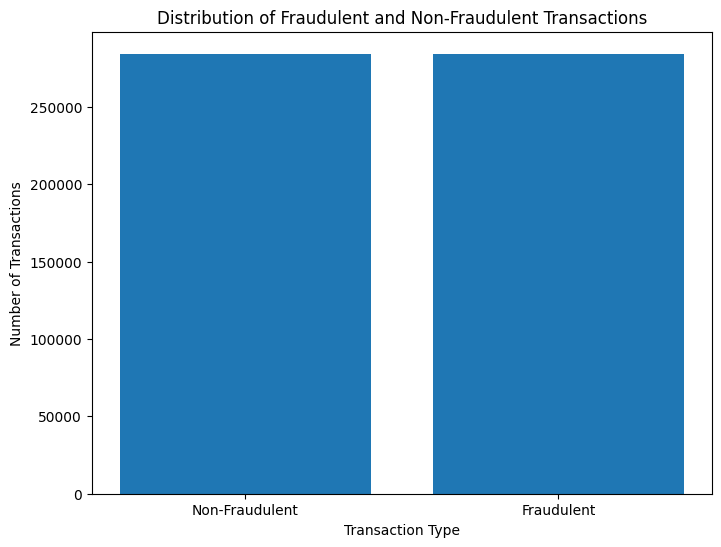

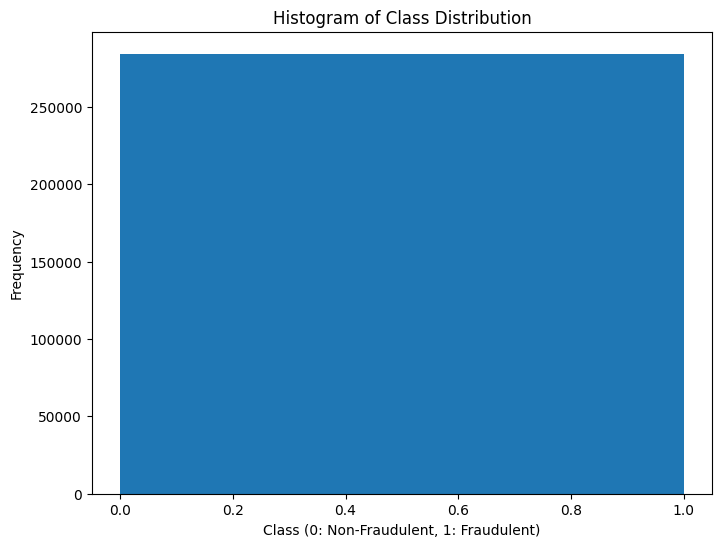

In [5]:

# Create a bar plot
plt.figure(figsize=(8, 6))
plt.bar(['Non-Fraudulent', 'Fraudulent'], df['Class'].value_counts())
plt.title("Distribution of Fraudulent and Non-Fraudulent Transactions")
plt.xlabel("Transaction Type")
plt.ylabel("Number of Transactions")
plt.show()

# Create a histogram
plt.figure(figsize=(8, 6))
plt.hist(df['Class'], bins=2)  # Two bins for binary classification
plt.title("Histogram of Class Distribution")
plt.xlabel("Class (0: Non-Fraudulent, 1: Fraudulent)")
plt.ylabel("Frequency")
plt.show()

Balanced Classes: If your classes are roughly equal in size, random sampling is generally appropriate.


In [6]:

# # Remove duplicate rows
# df = df.drop_duplicates()

# # Set the desired number of rows to keep
# desired_rows = 120000  # Adjust as needed almost 20%

# # Randomly sample the specified number of rows
# df_sampled = df.sample(n=desired_rows, random_state=42)  # Set a random state for reproducibility

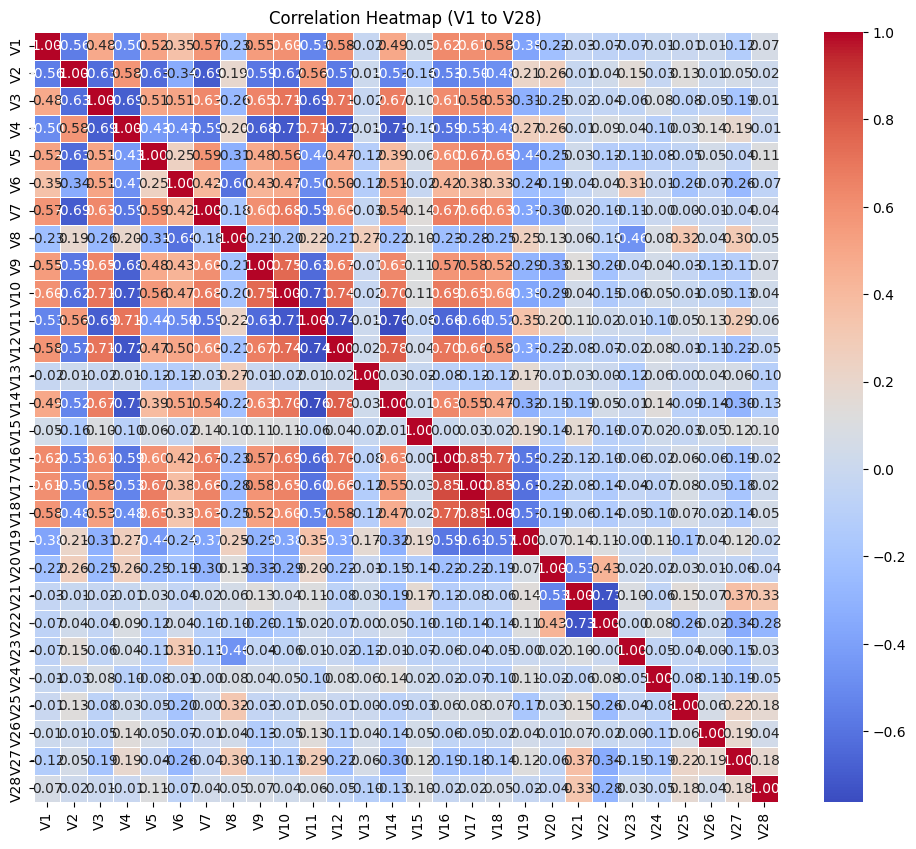

In [7]:

# Select only the columns V1 to V28 for correlation analysis
selected_columns = df.loc[:, 'V1':'V28']
# Calculate correlation matrix
correlation_matrix = selected_columns.corr()

# Create a heatmap to visualize correlations
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=True, fmt=".2f", linewidths=.5)
plt.title('Correlation Heatmap (V1 to V28)')
plt.show()

In [8]:

# Identify highly correlated features
threshold = 0.8  # Set your correlation threshold
highly_correlated_features = set()
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > threshold:
            colname = correlation_matrix.columns[i]
            highly_correlated_features.add(colname)

# Exclude 'id' and 'Class' from dropping
highly_correlated_features -= {'id', 'Class', 'Amount'}

# Display highly correlated features
print("Highly Correlated Features:", list(highly_correlated_features))


Highly Correlated Features: ['V17', 'V18']


In [9]:

# Use SelectKBest to choose the best features based on ANOVA F-value
k_best = 20  # Set the number of best features to select
feature_selector = SelectKBest(f_classif, k=k_best)

# Fit the feature selector to the data
X = selected_columns
y = df['Class']  # Assuming 'Class' is the target variable
X_best = feature_selector.fit_transform(X, y)

# Get the selected features
selected_features = X.columns[feature_selector.get_support()]

# Display the selected features
print("Selected Features:", list(selected_features))


Selected Features: ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V14', 'V16', 'V17', 'V18', 'V19', 'V20', 'V24', 'V27']


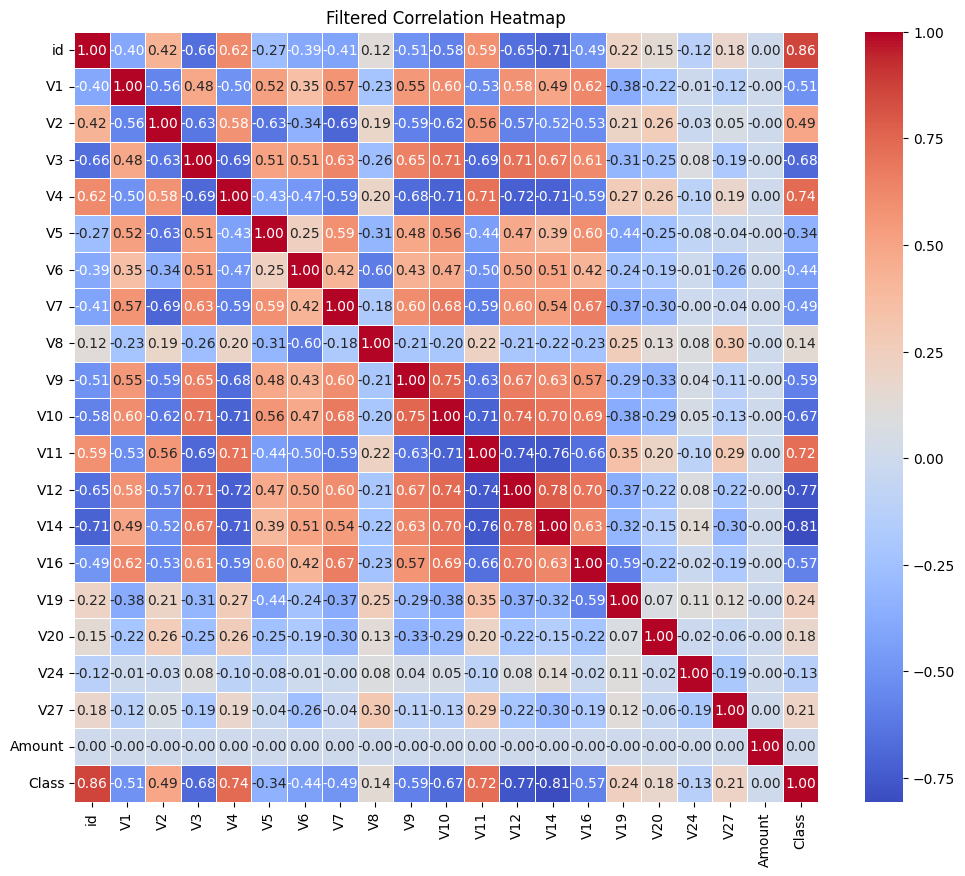

In [10]:

# Drop highly correlated and unselected features from the DataFrame
features_to_drop = highly_correlated_features.union(set(X.columns) - set(selected_features))
df_filtered = df.drop(columns=features_to_drop)

# Calculate correlation matrix for the filtered DataFrame
filtered_correlation_matrix = df_filtered.corr()

# Create a heatmap to visualize correlations of the filtered DataFrame
plt.figure(figsize=(12, 10))
sns.heatmap(filtered_correlation_matrix, cmap='coolwarm', annot=True, fmt=".2f", linewidths=.5)
plt.title('Filtered Correlation Heatmap')
plt.show()


In [11]:

# Calculate the total number of transactions
total_transactions = len(df_filtered)

# Count the number of fraudulent and non-fraudulent transactions
fraudulent_transactions = df_filtered['Class'].sum()  # Assuming 1 represents fraudulent
non_fraudulent_transactions = total_transactions - fraudulent_transactions

# Calculate the percentages
fraudulent_percentage = (fraudulent_transactions / total_transactions) * 100
non_fraudulent_percentage = (non_fraudulent_transactions / total_transactions) * 100

# Print the results
print("Percentage of fraudulent transactions:", fraudulent_percentage)
print("Percentage of non-fraudulent transactions:", non_fraudulent_percentage)

Percentage of fraudulent transactions: 50.0
Percentage of non-fraudulent transactions: 50.0


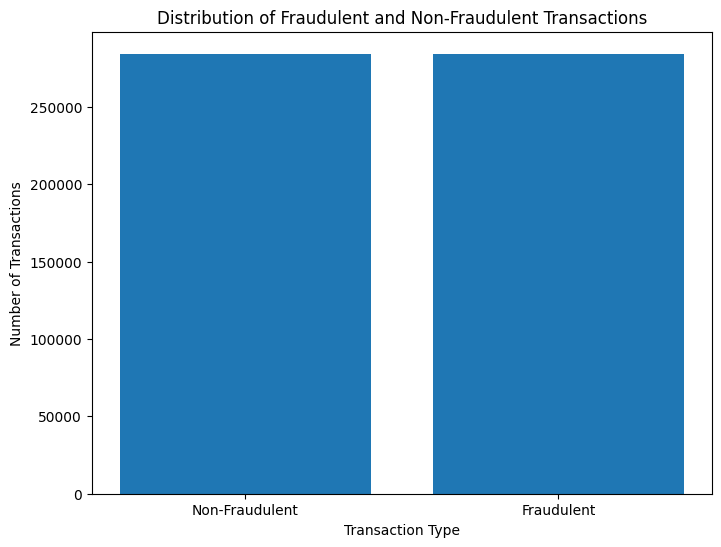

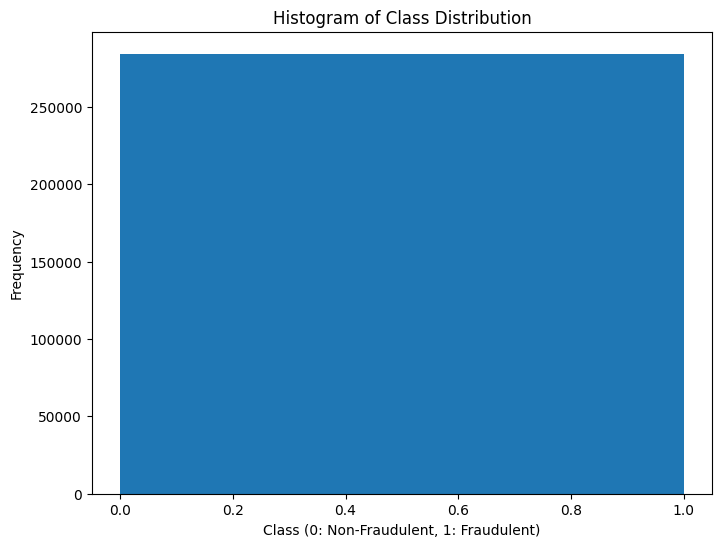

In [12]:

# Create a bar plot
plt.figure(figsize=(8, 6))
plt.bar(['Non-Fraudulent', 'Fraudulent'], df_filtered['Class'].value_counts())
plt.title("Distribution of Fraudulent and Non-Fraudulent Transactions")
plt.xlabel("Transaction Type")
plt.ylabel("Number of Transactions")
plt.show()

# Create a histogram
plt.figure(figsize=(8, 6))
plt.hist(df_filtered['Class'], bins=2)  # Two bins for binary classification
plt.title("Histogram of Class Distribution")
plt.xlabel("Class (0: Non-Fraudulent, 1: Fraudulent)")
plt.ylabel("Frequency")
plt.show()

While the dataset overall has a 50/50 balance, random sampling could inadvertently create splits that don't accurately reflect this distribution.
Stratified sampling guarantees that both the training and testing sets maintain the same class proportions, ensuring consistency and preventing potential biases in model training and evaluation.

In [13]:

# Use StratifiedShuffleSplit for the initial split
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in sss.split(df_filtered.drop(["Class"], axis=1), df_filtered["Class"]):
    X_train, X_val_test = df_filtered.drop(["Class"], axis=1).iloc[train_index], df_filtered.drop(["Class"], axis=1).iloc[test_index]
    y_train, y_val_test = df_filtered["Class"].iloc[train_index], df_filtered["Class"].iloc[test_index]

# Further split the testing set into testing and validation
X_test, X_val, y_test, y_val = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=42)
X_val = np.ascontiguousarray(X_val)
y_val = np.ascontiguousarray(y_val)
X_test = np.ascontiguousarray(X_test)
y_test = np.ascontiguousarray(y_test)




In [14]:
# Calculate the number of fraudulent and non-fraudulent transactions in each set
fraud_train = y_train.sum()
non_fraud_train = len(y_train) - fraud_train
fraud_test = y_test.sum()
non_fraud_test = len(y_test) - fraud_test

# Print the distributions
print("Training set:")
print("  Number of fraudulent transactions:", fraud_train)
print("  Number of non-fraudulent transactions:", non_fraud_train)

print("Testing set:")
print("  Number of fraudulent transactions:", fraud_test)
print("  Number of non-fraudulent transactions:", non_fraud_test)


Training set:
  Number of fraudulent transactions: 227452
  Number of non-fraudulent transactions: 227452
Testing set:
  Number of fraudulent transactions: 28591
  Number of non-fraudulent transactions: 28272


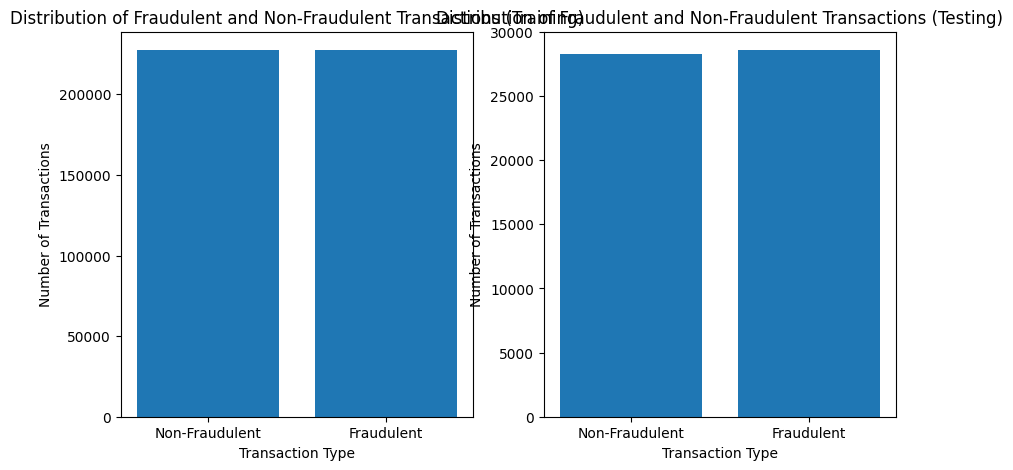

In [15]:

# Create bar plots
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.bar(['Non-Fraudulent', 'Fraudulent'], [non_fraud_train, fraud_train])
plt.title("Distribution of Fraudulent and Non-Fraudulent Transactions (Training)")
plt.xlabel("Transaction Type")
plt.ylabel("Number of Transactions")

plt.subplot(1, 2, 2)
plt.bar(['Non-Fraudulent', 'Fraudulent'], [non_fraud_test, fraud_test])
plt.title("Distribution of Fraudulent and Non-Fraudulent Transactions (Testing)")
plt.xlabel("Transaction Type")
plt.ylabel("Number of Transactions")

plt.show()


Enhancing Recall: Even with a balanced split, oversampling can further improve recall, which is crucial in fraud detection to minimize missed fraudulent transactions.
Countering Algorithm Bias: Some algorithms might still exhibit a slight bias towards the majority class. Oversampling helps mitigate this.
Avoiding Overfitting: Your dataset is large enough that oversampling is unlikely to cause significant overfitting.
SMOTE: This well-established technique creates synthetic minority class samples, potentially leading to better generalization than simple random oversampling.


In [16]:

# Apply SMOTE oversampling to the training set only
sm = SMOTE(random_state=42)  # Set random_state for reproducibility
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

In [17]:
# Calculate the number of fraudulent and non-fraudulent transactions in each set
fraud_train = y_train_res.sum()
non_fraud_train = len(y_train_res) - fraud_train
# Print the distributions
print("Training set:")
print("  Number of fraudulent transactions:", fraud_train)
print("  Number of non-fraudulent transactions:", non_fraud_train)


Training set:
  Number of fraudulent transactions: 227452
  Number of non-fraudulent transactions: 227452


In [18]:

# Define and train KNN models with k=1 and k=3
knn_1 = KNeighborsClassifier(n_neighbors=1, metric='manhattan')
# knn_1 = KNeighborsClassifier(n_neighbors=1)

knn_1.fit(X_train_res.values, y_train_res.values)

knn_3 = KNeighborsClassifier(n_neighbors=3, metric='manhattan')
# knn_3 = KNeighborsClassifier(n_neighbors=3)

knn_3.fit(X_train_res.values, y_train_res.values)
# Predict labels on the validation set
y_pred_1 = knn_1.predict(X_val)
y_pred_3 = knn_3.predict(X_val)

# Evaluate performance metrics
metrics = ['Accuracy', 'Precision', 'Recall', 'F1', 'AUC-ROC']

for metric in metrics:
    if metric == 'Accuracy':
        score_1 = accuracy_score(y_val, y_pred_1)
        score_3 = accuracy_score(y_val, y_pred_3)
    elif metric == 'Precision':
        score_1 = precision_score(y_val, y_pred_1)
        score_3 = precision_score(y_val, y_pred_3)
    elif metric == 'Recall':
        score_1 = recall_score(y_val, y_pred_1)
        score_3 = recall_score(y_val, y_pred_3)
    elif metric == 'F1':
        score_1 = f1_score(y_val, y_pred_1)
        score_3 = f1_score(y_val, y_pred_3)
        #  Area Under the Receiver Operating Characteristic curve for binary classification
    elif metric == 'AUC-ROC':
        score_1 = roc_auc_score(y_val, y_pred_1)
        score_3 = roc_auc_score(y_val, y_pred_3)
    print(f"{metric} for k=1: {score_1:.4f}")
    print(f"{metric} for k=3: {score_3:.4f}")

Accuracy for k=1: 0.9983
Accuracy for k=3: 0.9990
Precision for k=1: 0.9984
Precision for k=3: 0.9998
Recall for k=1: 0.9981
Recall for k=3: 0.9982
F1 for k=1: 0.9982
F1 for k=3: 0.9990
AUC-ROC for k=1: 0.9983
AUC-ROC for k=3: 0.9990
